<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://d1m75rqqgidzqn.cloudfront.net/wp-data/2019/09/11134058/What-is-data-science-2.jpg" 
     style="display: block; margin-left: auto; margin-right: auto;";/>
</div>

# 1.0 Introduction

<b>1.1 Purpose:</b> Uncover the intricate connections between geographic, weather, soil, and farm management features, all leading to a prediction of yield

<b>1.2 Mission:</b> To decode these relationships and empower farmers with actionable insights for improved productivity and informed decision-making.

In this project, I will apply regression concepts and techniques to agricultural yield prediction. Through a series of challenges, I aim to accomplish the following:

* Analyse predictor variables and their relationship with the target variable.
* Perform feature engineering tasks, including encoding categorical variables and scaling features.
* Construct and evaluate multiple linear regression models using appropriate libraries.
* Identify and address multicollinearity issues using regularisation techniques such as LASSO and Ridge regression.
* Interpret regression coefficients and understand their impact on the target variable.
* Implement decision tree models for prediction tasks, exploring both categorical and numerical data
* Calculate and interpret MSE and RMSE for model evaluation.

## 2.0 Data dictionary

The data is stored in a sqlite database. These are the tables:

**2.1 Geographic features**

- **Field_ID:** A unique identifier for each field (BigInt).
 
- **Elevation:** The elevation of the field above sea level in metres (Float).

- **Latitude:** Geographical latitude of the field in degrees (Float). (DUMMY VARIABLE- the simulation might have created a relationship)

- **Longitude:** Geographical longitude of the field in degrees (Float). (DUMMY VARIABLE- the simulation might have created a relationship)

- **Location:** Province the field is in (Text).

- **Slope:** The slope of the land in the field (Float).

**2.2 Weather features**

- **Rainfall:** Amount of rainfall in the area in mm (Float).

- **Min_temperature_C:** Average minimum temperature recorded in Celsius (Float).(DUMMY VARIABLE)

- **Max_temperature_C:** Average maximum temperature recorded in Celsius (Float).(DUMMY VARIABLE)

- **Ave_temps:** Average temperature in Celcius (Float).

**2.3 Soil and crop features**

- **Soil_fertility:** A measure of soil fertility where 0 is infertile soil, and 1 is very fertile soil (Float).

- **Soil_type:** Type of soil present in the field (Text).

- **pH:** pH level of the soil, which is a measure of how acidic/basic the soil is (Float).

**2.4 Farm management features**

- **Field_ID:** Corresponding field identifier (BigInt).

- **Pollution_level:** Level of pollution in the area where 0 is unpolluted and 1 is very polluted (Float).

- **Plot_size:** Size of the plot in the field (Ha) (Float). (DUMMY VARIABLE)

- **Chosen_crop:** Type of crop chosen for cultivation (Text).

- **Annual_yield:** Annual yield from the field (Float). This is the total output of the field. The field size and type of crop will affect the Annual Yield (DUMMY VARIABLE - Removed)

<br>

**2.5 Target variable**
- **Standard_yield:** Standardised yield expected from the field, normalised per crop (Float). This is independent of field size, or crop type. Multiplying this number by the field size, and average crop yield will give the Annual_Yield.

---

In the previous project, I created a data pipeline package which contained data_ingestion and field_data_processor files. I will use these modules for data cleaning

**Important:** I ensured that `data_ingestion.py` file and the `field_data_processor.py` files are stored in the same folder as my notebook, otherwise the data import will fail.
 
[Download files here](https://github.com/Explore-AI/Public-Data/raw/master/Maji_Ndogo/modules.zip)

[Download database here](https://github.com/BlackIG/packages/blob/main/DataPipeline/datapipeline/Maji_Ndogo_farm_survey_small.db)

## 3.0 Regression Analysis

In [4]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.graphics.correlation as sgc
from statsmodels.graphics.gofplots import qqplot
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import OLSInfluence
import seaborn as sns

In [5]:
# Read the database, and clean the data using the processing modules I built.

import re
import numpy as np
import pandas as pd
from field_data_processor import FieldDataProcessor
import logging 

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

config_params = {
    "sql_query": """
            SELECT *
            FROM geographic_features
            LEFT JOIN weather_features USING (Field_ID)
            LEFT JOIN soil_and_crop_features USING (Field_ID)
            LEFT JOIN farm_management_features USING (Field_ID)
            """,
    "db_path": 'sqlite:///Maji_Ndogo_farm_survey_small.db',
    "columns_to_rename": {'Annual_yield': 'Crop_type', 'Crop_type': 'Annual_yield'},
    "values_to_rename": {'cassaval': 'cassava', 'wheatn': 'wheat', 'teaa': 'tea', 'tea ':'tea','wheat ':'wheat','cassava ':'cassava'},
    "weather_csv_path": "https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Maji_Ndogo/Weather_station_data.csv",
    "weather_mapping_csv": "https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Maji_Ndogo/Weather_data_field_mapping.csv",
    "regex_patterns" : {
            'Rainfall': r'(\d+(\.\d+)?)\s?mm',
            'Temperature': r'(\d+(\.\d+)?)\s?C',
            'Pollution_level': r'=\s*(-?\d+(\.\d+)?)|Pollution at \s*(-?\d+(\.\d+)?)'
            },
}
# Ignoring the field data for now.
field_processor = FieldDataProcessor(config_params)
field_processor.process()
field_df = field_processor.df

dataset = field_df.drop("Weather_station", axis=1)

2024-04-11 08:30:10,310 - data_ingestion - INFO - Database engine created successfully.
2024-04-11 08:30:10,390 - data_ingestion - INFO - Query executed successfully.
2024-04-11 08:30:10,390 - field_data_processor.FieldDataProcessor - INFO - Sucessfully loaded data.
2024-04-11 08:30:10,390 - field_data_processor.FieldDataProcessor - INFO - Swapped columns: Annual_yield with Crop_type
2024-04-11 08:30:11,806 - data_ingestion - INFO - CSV file read successfully from the web.


Before diving into  analysis, it's crucial to ensure the integrity of the dataset and that the data is still as I expect it to be.

In [6]:
# Validate the data
#!pip install pytest

dataset.to_csv('sampled_field_df.csv', index=False)

!pytest validate_data.py -v

import os# Define the file paths
field_csv_path = 'sampled_field_df.csv'

# Delete sampled_field_df.csv if it exists
if os.path.exists(field_csv_path):
    os.remove(field_csv_path)
    print(f"Deleted {field_csv_path}")
else:
    print(f"{field_csv_path} does not exist.")

============================= test session starts =============================
platform win32 -- Python 3.11.5, pytest-7.4.0, pluggy-1.0.0 -- C:\Users\ichilaka\AppData\Local\anaconda3\python.exe
cachedir: .pytest_cache
rootdir: C:\Users\ichilaka\Downloads
plugins: anyio-3.5.0
collecting ... collected 4 items

validate_data.py::test_read_field_dataframe_shape PASSED                 [ 25%]
validate_data.py::test_field_dataframe_columns PASSED                    [ 50%]
validate_data.py::test_field_dataframe_non_negative_elevation PASSED     [ 75%]
validate_data.py::test_crop_types_are_valid PASSED                       [100%]

============================== 4 passed in 0.68s ==============================
Deleted sampled_field_df.csv


### 3.1: Understanding the variables and variable selection

In this section, I will analyse the predictor variables in the dataset and how they relate to the target variable.

**3.1.1 How many predictors do we originally have in our dataset, and which of these are categorical in nature?**

The `Field_ID` serves as a unique identifier for each field and does not provide any predictive value for modeling.

In [7]:
target_variable = 'Standard_yield'
unique_identifier = 'Field_ID'

# Extracting predictors excluding target_variable and unique_identifier
no_of_predictors = [col for col in dataset.columns if col != target_variable and col != unique_identifier]

# Check if each column in the list of predictors is non-numeric (i.e., categorical)
categorical_variables = [col for col in no_of_predictors if dataset[col].dtype == 'object']

print("{} predictors; {} are categorical".format(len(no_of_predictors), ", ".join(categorical_variables)))

16 predictors; Location, Soil_type, Crop_type are categorical


**3.1.2 The categorical features in this dataset need to be converted into a format suitable for modeling. I will apply dumm y  variable encoding to these categorical features**


In [8]:
#exclude Field_ID
dataset_nofield = dataset.drop(columns=['Field_ID'])

#apply variable encoding
dataset_new = pd.get_dummies(dataset_nofield, drop_first=True)

#independent_variables - excluding target
independent_variables = [col for col in dataset_new.columns if col != target_variable]
print("There are {} independent variables". format(len(independent_variables)))

There are 29 independent variables


**3.1.3 From my encoded dataset, I wish to see absolute correlation of variables with the `Standard_yield`?**

In [9]:
#correlation value in descending order
correlation_series = abs(dataset_new.corr()['Standard_yield']).sort_values(ascending=False)
correlation_series

Standard_yield             1.000000
Crop_type_tea              0.432879
Soil_type_Volcanic         0.309982
Pollution_level            0.285761
Crop_type_coffee           0.222217
Annual_yield               0.220812
Location_Rural_Sokoto      0.212337
Soil_type_Silt             0.205861
pH                         0.196613
Crop_type_cassava          0.186716
Crop_type_potato           0.175484
Soil_type_Sandy            0.164714
Min_temperature_C          0.144233
Soil_type_Peaty            0.135509
Elevation                  0.129248
Max_temperature_C          0.111649
Location_Rural_Hawassa     0.110623
Crop_type_rice             0.104056
Crop_type_wheat            0.092420
Longitude                  0.085343
Soil_type_Rocky            0.078355
Soil_fertility             0.070205
Latitude                   0.061724
Slope                      0.056991
Rainfall                   0.039217
Location_Rural_Amanzi      0.032049
Plot_size                  0.017014
Location_Rural_Kilimani    0

**3.1.4. In order to fit an ordinary least squares regression model (OLS) to my encoded data, I would need to make sure that all the variables are numeric. Through dummy variable encoding, I have converted the categorical variables to multiple int/boolean variables. The `sm.OLS()` method itself does not inherently handle boolean data types implicitly.**

In most cases, when fitting a model with sm.OLS(), it is essential to ensure that all features are numeric. If boolean columns are present, they should be explicitly converted to numeric types before fitting the model.

The boolean columns will be replaced with binary integer representations, with True converted to 1 and False converted to 0.

In [10]:
#create copy of the df and select boolean columns
dataset_copy = dataset_new.copy()
boolean_columns = dataset_copy.select_dtypes(include=['bool']).columns

#convert to integers
dataset_copy[boolean_columns] = dataset_copy[boolean_columns].astype(int)

**3.1.5 I wish to determine which of the predictors in my dataset are statistically significant. I will follow the following steps:**

* Fit a statsmodels regression model to predict `Standard_yield` using my encoded dataset.
* Extract p-values for each predictor from the fitted model to find the ones that are significant based on a given threshold.

In [11]:
import statsmodels.api as sm

X = dataset_copy.drop(columns=['Standard_yield'])
y = dataset_copy['Standard_yield']

# Add a constant to the independent variable set for the intercept in the model
X_const = sm.add_constant(X)

# Fit the Ordinary Least Squares (OLS) model with the updated data
model = sm.OLS(y, X_const).fit()

# Get the summary of the updated model to extract p-values and other statistics
model_summary = model.summary()

# Extract p-values and sort
p_values = model.pvalues
print(p_values.sort_values())

model_summary
#The extremely low p-value suggests a strong association with Standard_yield

Plot_size                   0.000000e+00
Annual_yield                0.000000e+00
Pollution_level            5.588050e-247
Crop_type_tea              7.595539e-197
Crop_type_potato           5.443582e-141
Soil_type_Silt             9.623895e-136
Soil_type_Sandy            1.761947e-120
Crop_type_rice             1.519311e-117
Soil_type_Rocky             6.256187e-84
Soil_type_Peaty             1.000074e-61
Crop_type_wheat             3.750143e-50
pH                          7.425131e-47
Soil_type_Volcanic          6.050057e-36
Crop_type_maize             1.016239e-31
Crop_type_cassava           1.131029e-22
Location_Rural_Sokoto       4.320614e-14
const                       1.428115e-04
Latitude                    7.507619e-04
Location_Rural_Kilimani     1.875099e-03
Longitude                   3.686453e-02
Rainfall                    5.666955e-02
Slope                       7.690853e-02
Soil_fertility              1.667017e-01
Max_temperature_C           1.843501e-01
Location_Rural_A

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Standard_yield   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     623.8
Date:                Thu, 11 Apr 2024   Prob (F-statistic):               0.00
Time:                        08:30:14   Log-Likelihood:                 8358.2
No. Observations:                5654   AIC:                        -1.666e+04
Df Residuals:                    5625   BIC:                        -1.647e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.6982      0.183      3.806      0.000       0.339       1.058
Elevation               -6.517e-05      0.000     -0.628      0.530      -0.000       0.000
Latitude                   -0.0023      0.001     -3.372      0.001      -0.004      -0.001
Longitude                  -0.0014      0.001     -2.088      0.037      -0.003   -8.32e-05
Slope                       0.0014      0.001      1.769      0.077      -0.000       0.003
Rainfall                  4.27e-05   2.24e-05      1.906      0.057   -1.21e-06    8.66e-05
Min_temperature_C           0.0121      0.010      1.273      0.203      -0.007       0.031
Max_temperature_C          -0.0026      0.002     -1.328      0.184      -0.006       0.001
Ave_temps                   0.0048      0.004      1.250      0.211      -0.003       0.012
Soil_fertility             -0.3560      0.257     -1.383      0.167      -0.861       0.149
pH                          0.0206      0.001     14.509      0.000       0.018       0.023
Pollution_level            -0.1665      0.005    -35.319      0.000      -0.176      -0.157
Plot_size                  -0.0429      0.001    -50.411      0.000      -0.045      -0.041
Annual_yield                0.0811      0.002     53.269      0.000       0.078       0.084
Location_Rural_Amanzi       0.0062      0.005      1.325      0.185      -0.003       0.015
Location_Rural_Hawassa     -0.0001      0.003     -0.040      0.968      -0.007       0.007
Location_Rural_Kilimani     0.0128      0.004      3.111      0.002       0.005       0.021
Location_Rural_Sokoto       0.0355      0.005      7.570      0.000       0.026       0.045
Soil_type_Peaty            -0.0963      0.006    -16.784      0.000      -0.108      -0.085
Soil_type_Rocky            -0.1022      0.005    -19.741      0.000      -0.112      -0.092
Soil_type_Sandy            -0.0744      0.003    -23.917      0.000      -0.081      -0.068
Soil_type_Silt             -0.1178      0.005    -25.492      0.000      -0.127      -0.109
Soil_type_Volcanic         -0.0534      0.004    -12.605      0.000      -0.062      -0.045
Crop_type_cassava           0.0344      0.003      9.842      0.000       0.028       0.041
Crop_type_coffee           -0.0029      0.003     -0.891      0.373      -0.009       0.004
Crop_type_maize             0.0505      0.004     11.792      0.000       0.042       0.059
Crop_type_potato            0.0998      0.004     26.015      0.000       0.092       0.107
Crop_type_rice              0.1011      0.004     23.605      0.000       0.093       0.110
Crop_type_tea               0.1162      0.004     31.166      0.000       0.109       0.123
Crop_type_wheat             0.0468      0.003     15.040      0.000       0.041       0.053
===============================================

### 3.2 Generating a multiple linear regression model

After encoding the variables and performing preliminary analysis, I will continue to identify the variables that will enable me  construct the most accurate multiple linear regression model possible with the data that I have.

**3.2.1 I will create another correlation matrix using all the columns in my encoded dataset and display it as a heatmap.**

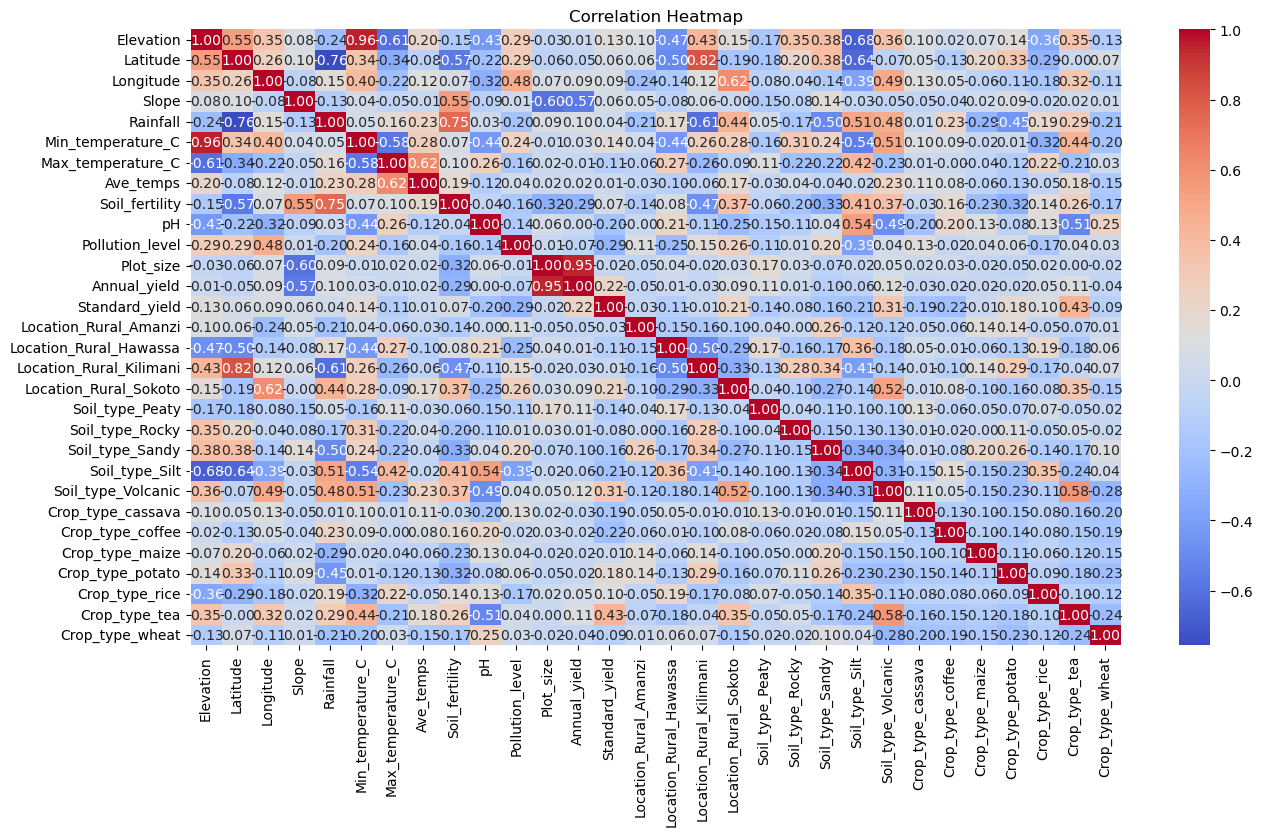

In [12]:
# Create the correlation_matrix
corr_matrix = dataset_copy.corr()

#plot the heatmap
plt.figure(figsize=(15,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [13]:
# Check this out Which of the following independent variables have a strong correlation with one another.

print('Plot_size and Crop_type_tea:', corr_matrix.loc['Plot_size', 'Crop_type_tea'])
print('Pollution_level and Soil_type_Rocky:', corr_matrix.loc['Pollution_level', 'Soil_type_Rocky'])
print('Crop_type_cassava and Soil_type_Sandy:', corr_matrix.loc['Crop_type_cassava', 'Soil_type_Sandy'])
print('Min_temperature_C and Elevation:', corr_matrix.loc['Min_temperature_C', 'Elevation']) #strongest, close to 1

Plot_size and Crop_type_tea: 9.986874953491619e-05
Pollution_level and Soil_type_Rocky: 0.012915216253655576
Crop_type_cassava and Soil_type_Sandy: -0.0058273536788906585
Min_temperature_C and Elevation: 0.9564181399438557


**3.2.2 Now that I have analysed the variables, I will fit an ordinary least squares regression model using all the independent variables on `statsmodels.formula.api` smf and then print the model summary.**


The F-statistic tests the overall significance of the regression model. A high F-statistic value with a corresponding low p-value indicates that the regression model is statistically significant, meaning that at least one of the independent variables has a significant effect on the dependent variable.

In [14]:
# Create the formula, excluding 'Field_ID' and using 'Standard_yield' as the dependent variable
independent_vars = '+'.join([col for col in dataset_copy.columns if col not in ['Standard_yield']])
formula = f'Standard_yield ~ {independent_vars}'

# Fit the OLS model using the formula interface
model2 = smf.ols(formula, data=dataset_copy).fit()

# Print the summary of the model
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:         Standard_yield   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     623.8
Date:                Thu, 11 Apr 2024   Prob (F-statistic):               0.00
Time:                        08:30:16   Log-Likelihood:                 8358.2
No. Observations:                5654   AIC:                        -1.666e+04
Df Residuals:                    5625   BIC:                        -1.647e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

**3.2.3 This summary gives an indication of possible multicollinearity present within our predictor variables. The presence of any correlation among predictors is detrimental to model quality because it tends to increase the standard error of the coefficients and it becomes difficult to estimate the effect of any one predictor variable on the response variable.**

To avoid this, I will reduce the number of independent variables included in the model. Let me fit the model using the following variables:

* `Pollution_level` 
* `Crop_type_coffee` 
* `Crop_type_tea`
* `Location_Rural_Sokoto`
* `Annual_yield` 
* `Soil_type_Silt`
* `Soil_type_Volcanic`

In [15]:
# Your code here
variable_set = ['Pollution_level','Crop_type_coffee','Crop_type_tea','Location_Rural_Sokoto',
                'Annual_yield','Soil_type_Silt','Soil_type_Volcanic', 'Standard_yield']
dataset3 = dataset_copy[variable_set]

#Create the formula, excluding 'Field_ID' and using 'Standard_yield' as the dependent variable
independent_vars3 = '+'.join([col for col in dataset3.columns if col not in ['Standard_yield']])
formula3 = f'Standard_yield ~ {independent_vars3}'

# Fit the OLS model using the formula interface
model3 = smf.ols(formula3, data=dataset3).fit()

# Print the summary of the model
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:         Standard_yield   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     552.1
Date:                Thu, 11 Apr 2024   Prob (F-statistic):               0.00
Time:                        08:30:16   Log-Likelihood:                 5839.8
No. Observations:                5654   AIC:                        -1.166e+04
Df Residuals:                    5646   BIC:                        -1.161e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.56

After reducing the number of dependent variables accordingly, how did the model change?

The Conditional Number decreased which indicates reduced multicollinearity but the R-squared reduced also which indicates that the reduction in the ability of the model to explain variance.

With regard to the specific criteria of reducing multicollinearity, the model improved

**3.2.4 I will evaluate the model's results by generating a scatter plot of the residuals against the fitted values allowing me to visually inspect whether the residuals have constant variance and are distributed randomly around the zero residual line.**

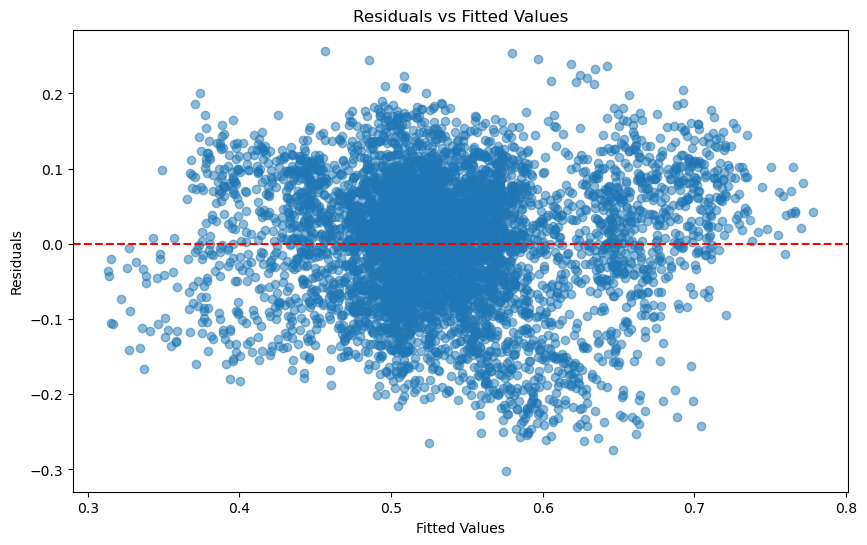

In [16]:
fitted_values = model3.fittedvalues
residuals = model3.resid

# Create the scatter plot of residuals against fitted values
plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

plt.show()

There is no clear pattern, such as a funnel shape or systematic curve, which is a good sign. The residuals appear to be relatively evenly distributed across the range of fitted values. The cloud of points seems to have a consistent spread across the zero line, which suggests homoscedasticity.

However, there is a noticeable concentration of data points around the center, which could be a natural outcome due to the density of data points in that region or could suggest some minor issues.

**3.2.5 If a linear regression model indicated heteroscedasticity, the following actions could be considered to address this issue:**

* Applying transformations to the independent variables to better fit the linear relationship.
* Implementing weighted least squares regression to give less emphasis to observations with higher variance in residuals.
* Removing outliers from the dataset to reduce the impact of extreme values on the variance of residuals.

### 3.3 Using regularisation to optimise agricultural yield

After fitting our model, I realize I need to explore more ways to implement feature engineering and data pre-processing in order to optimise the model. I suspect that, if I use all the variables available, the model might overfit due to the high dimensionality of the data. 

Regularisation techniques will therefore be critical in building a predictive model that generalises well to new, unseen data.

**3.3.1 My first step in the feature engineering involves creating a new feature, `Temperature_Range`, and scaling features using `StandardScaler`. The difference between `Min_temperature_C` and `Max_temperature_C` is the temperature range.**

In [17]:
from sklearn.preprocessing import StandardScaler

# create the new feature
dataset['Temperature_Range'] = dataset['Max_temperature_C'] - dataset['Min_temperature_C']

# Select features for scaling (exclude non-numeric variables and target variable)
features = ['Elevation', 'Slope', 'Rainfall', 'Ave_temps', 'Temperature_Range', 'Soil_fertility', 'pH', 'Pollution_level']

# Initialise StandardScaler and apply it to the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataset[features])

# Show the first 5 rows of the scaled features
print(scaled_features[:5])

[[ 0.85426539  0.31997088 -0.15356676  2.21747303  0.30626766  0.01544079
   0.71256827 -0.61634976]
 [ 0.21055364 -0.03858151  0.49777372  0.15900087 -0.25298298  0.4619994
   0.08816394  0.7886906 ]
 [ 1.08748981 -0.04224188  2.01496684  0.09662293 -1.66755812  1.57839593
  -0.34858051  0.60254524]
 [-0.3620941  -0.4856324  -1.74719984 -0.02813296  0.8984154  -1.77079366
  -0.35345077  0.28374058]
 [ 1.43215211  4.53523034 -0.83392242  1.28180387 -0.58195394  2.24823384
   0.14466333 -0.80437805]]


### Let me digress a little and consider other feature engineering methods

**3.3.2 Consider a scenario where I decide to employ LASSO regression to identify predictive features associated with our dependent variable.**

*cv=5 indicates that 5-fold cross-validation should be used to select the best regularisation parameter.*

In [18]:
from sklearn.linear_model import LassoCV

# scaled_features is our matrix of scaled features and dataset['Standard_yield'] is the target variable
lasso = LassoCV(cv=5).fit(scaled_features, dataset['Standard_yield'])

# Find the features with non-zero coefficients
selected_features = [features[i] for i, coef in enumerate(lasso.coef_) if coef != 0]
selected_features

['Elevation',
 'Slope',
 'Rainfall',
 'Ave_temps',
 'Temperature_Range',
 'pH',
 'Pollution_level']

**3.3.3 In trying to address multicollinearity in the dataset, I could also decide to implement Ridge regression. After understanding that Ridge regression applies an L2 penalty to the coefficients to reduce their magnitude without setting them to zero as Lasso (L1), I could decide to use `RidgeCV` for applying Ridge regression with cross-validation to select the optimal penalty strength.**

In [19]:
from sklearn.linear_model import RidgeCV

alphas=[0.001, 0.01, 0.1, 1, 10, 100]

# Apply Ridge regression with cross-validation
ridge = RidgeCV(alphas=alphas, cv=5).fit(scaled_features, dataset['Standard_yield'])

**3.3.4 Given our dataset includes variables such as `Elevation` and `Slope`, and considering the potential interactions between these variables might impact crop yield, I aim to capture both these interactions and possible non-linear relationships by creating a quadratic interaction term without including an intercept in the feature set?**

In [20]:
from sklearn.preprocessing import PolynomialFeatures

# Generate polynomial and interaction features
poly = PolynomialFeatures(degree=2, include_bias=False)

poly_features = poly.fit_transform(dataset[['Elevation', 'Slope']])

# Display the shape of the new feature matrix
poly_features.shape

(5654, 5)

**3.3.5 After implementing Ridge regression to address multicollinearity and prevent overfitting in the model, I need to interpret the coefficients to understand the impact of each feature on the standard yield.**

In [21]:
from sklearn.linear_model import Ridge
import numpy as np

# Assuming `X` is the feature matrix and `y` is the target variable
X = np.array([[0.5, 0.2, 0.1],
              [0.9, 0.3, 0.5],
              [0.3, 0.8, 0.2]])
y = np.array([0.7, 0.6, 0.8])

# Fit Ridge regression model with alpha = 0.1
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X, y)

# Display the coefficients of the model
ridge_model.coef_

array([-0.13661379,  0.10262221, -0.07348657])

**Feature 2 has the highest positive impact, while Feature 3 and Feature 1 have negative impacts.**

### 3.4: Making a prediction using decision trees

Decision trees are easy to implement and are capable of handling both categorical and numerical data while being resilient to outliers, I will implement a decision tree on our encoded dataset for this reason

**3.4.1 I will train a decision tree with the following steps:**

* Using our **previously encoded dataset**, I will split the data into dependent and independent variables using all the features except for `Standard_yield` and `Field_ID` as independent variables.
* Then split the data into training and testing data.
* Also, I will use the `DecisionTreeRegressor` to fit a model using a `max_depth' of 2 and a `random_state` of 42.

Using the trained Decision Tree Regressor model, I will then make a prediction for `y` given the following x-values:<br> 
`[864.66138, -8.12890218821531, -8.311822719284072, 16.274624300000003, 1237.7200000000003, -3.4100000000000006, 36.410000000000004,`
`16.5,0.682, 6.7863323423108195, 0.09379352739936421, 1.4300000000000002, 0.8264890400277934,0.0,0.0,0.0,0.0,0.0,0.0,1.1,0.0,0.0,1.1,0.0, 0.0,0.0,0.0,0.0,0.0]`

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

X = dataset_copy.drop(columns=['Standard_yield'])
y = dataset_copy['Standard_yield']

specimen_x = np.array([864.66138, -8.12890218821531, -8.311822719284072, 16.274624300000003, 1237.7200000000003, -3.4100000000000006, 
   36.410000000000004, 16.5, 0.682, 6.7863323423108195, 0.09379352739936421, 1.4300000000000002, 
   0.8264890400277934, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1, 0.0, 0.0, 1.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]).reshape(1, -1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the model with parameters
model = DecisionTreeRegressor(max_depth=2, random_state=42)
# Fit the model to the training data
model.fit(X_train, y_train)
# Use trained model to predict y from specimen_x
predicted_y = model.predict(specimen_x)

print(predicted_y[0])

0.48494414306304917


C:\Users\ichilaka\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


**3.4.2 Based on the model above, I will determine the RMSE value**

In [23]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:{}'.format(rmse))

RMSE:0.08805783663217344


**3.4.3 An RMSE of 0.0881 suggests that, on average, the predicted values are off by approximately 0.0881 units**

**3.4.4 I will like to examine the likely effect of adjusting the `max_depth` parameter in a Decision Tree model by plotting RMSE against max_depth to visualize this.**

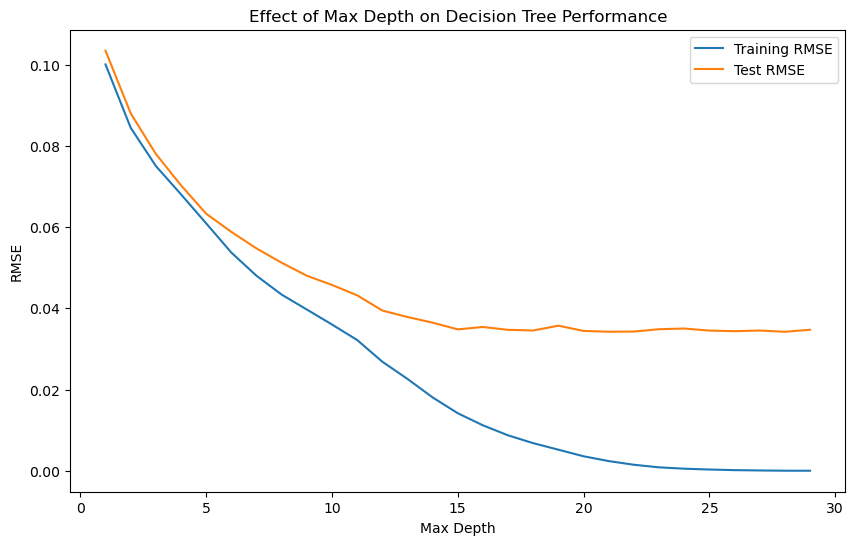

In [25]:
# Initialize lists to store RMSE values for different depths
train_rmse, test_rmse = [], []

# Try different values for max_depth and record the training and test RMSE
max_depth_range = range(1, 30)  
for depth in max_depth_range:
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    
    # Calculate RMSE for training data
    train_pred = model.predict(X_train)
    train_error = mean_squared_error(y_train, train_pred, squared=False)
    train_rmse.append(train_error)
    
    # Calculate RMSE for test data
    test_pred = model.predict(X_test)
    test_error = mean_squared_error(y_test, test_pred, squared=False)
    test_rmse.append(test_error)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, train_rmse, label='Training RMSE')
plt.plot(max_depth_range, test_rmse, label='Test RMSE')
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.title('Effect of Max Depth on Decision Tree Performance')
plt.legend()
plt.show()

**Higher max_depth values may lead to increased model complexity and a higher risk of overfitting.**

The flattening of the test RMSE curve suggests that while the model continues to fit the training data better  with increased depth, it does not necessarily lead to better generalization.

**3.4.5 I will attempt to enhance our model's performance by setting the `max_depth` hyperparameter to 5.**

In [24]:
#instantiate the model with parameters
model5 = DecisionTreeRegressor(max_depth=5, random_state=42)

#fit the model to the training data
model5.fit(X_train, y_train)

#find rmse 
np.sqrt(mean_squared_error(y_test, model5.predict(X_test)))

0.06332974532698206

**The decision tree model was improved by fitting it with a `max_depth` parameter of 5.**

### 3.5: Ensemble Methods & Bootstrapping

Using the original dataset, my objective is to explore ensemble methods and bootstrapping techniques to enhance the model performance. I will work with a subset of features from the dataset to predict the `Standard_yield`.

**3.5.1 To implement a bootstrap aggregation (bagging) for predicting the `Standard_yield` based on features `Elevation`, `Slope`, `Soil_fertility`, and `Pollution_level`, I have arranged the following steps**

1. Create an empty list named `predictions` to store predictions from each bootstrap sample.
2. Generate `n_bootstrap_samples` bootstrap samples from the original dataset.
3. For each bootstrap sample, fit a linear regression model and predict the `Standard_yield` on the entire dataset.
4. Store each set of predictions in the predictions list.
5. Average the predictions across all bootstrap samples to obtain the final bagged prediction.
6. Compute and print the mean squared error (MSE) to evaluate the performance of the bagged model.

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
import numpy as np

# X_train, y_train represent the features and target variable from the training data
X = dataset[['Elevation', 'Slope', 'Soil_fertility', 'Pollution_level']]
y = dataset['Standard_yield']

predictions = []
n_bootstrap_samples = 100

for _ in range(n_bootstrap_samples):
    X_sample, y_sample = resample(X, y)
    model = LinearRegression()
    model.fit(X_sample, y_sample)
    y_pred = model.predict(X)
    predictions.append(y_pred)

# MISSING PART HERE

# Calculate the average of predictions across all bootstrap samples
bagged_prediction = np.mean(predictions, axis=0)
mse_bagged = mean_squared_error(y, bagged_prediction)

print(f"Mean Squared Error of Bagged Linear Regression Models: {mse_bagged}")

Mean Squared Error of Bagged Linear Regression Models: 0.01084046691054758


**3.5.2 I will apply a `RandomForestRegressor` to the dataset. It is worthy of note that the max_features parameter in the `RandomForestRegressor` constructor is crucial for implementing the random subspace method by allowing the algorithm to select a random subset of features for each split**

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialise and train the random forest model
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X, y)

# Predict using the random forest model
y_pred_rf = rf_model.predict(X)

# Evaluate the model
mse_rf = mean_squared_error(y, y_pred_rf)
print(f"Mean Squared Error of Random Forest Regressor: {mse_rf}")

#By default, for regression problems, max_features is set to n_features in X

Mean Squared Error of Random Forest Regressor: 0.0011154533303463663


**3.5.3 Here is a theoretical setup for a stacking ensemble model designed for a regression task. The first layer of this model includes three different types of regression models: linear regression, ridge regression, and a support vector machine (SVM) with a linear kernel. The second layer, or the final estimator, uses a linear regression model to combine the predictions from the first layer.**

The goal is to theoretically predict `Standard_yield` based on features such as `Elevation`, `Slope`, `Soil_fertility`, and `Pollution_level`, with the intention to evaluate the model's hypothetical performance using the Mean Squared Error (MSE).

In [28]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error

# Define base learners
estimators = [
    ('lr', LinearRegression()),
    ('ridge', Ridge()),
    ('svr', SVR(kernel='linear')) #configure the SVM with a linear kernel as part of the base learners in the stacking model
]

# Define the theoretical stacking model
stacking_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

**3.5.4 Let me explore a 5-fold cross-validation scheme to estimate the accuracy of a ridge regression model. This model uses bootstrapped samples within each fold to predict `Standard_yield` and calculates the average Mean Squared Error (MSE) across all folds.**

In [29]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialise the ridge regression model
ridge_model = Ridge()

# Perform 5-fold cross-validation with bootstrapping
scores = cross_val_score(ridge_model, X, y, scoring='neg_mean_squared_error', cv=5) #add correct option here 

# Convert scores to positive MSE
mse_scores = -scores

# Calculate average MSE
average_mse = np.mean(mse_scores)
print(f"Average Mean Squared Error from Cross-Validation: {average_mse}")

Average Mean Squared Error from Cross-Validation: 0.010875483717316465


**3.5.5 I wish to extract and print the feature importances from a trained random forest regressor model. The model is used to predict `Standard_yield` based on various features. I utilised the `feature_importances_` attribute of the random forest model to obtain importance scores for each feature.**

The code below identifies and prints the importance scores for each feature in the random forest model, indicating how much each feature contributes to the model's ability to predict `Standard_yield`. Higher scores suggest a greater contribution to the prediction.

In [30]:
# Extract feature importances
feature_importances = rf_model.feature_importances_

# Print feature importances
for feature, importance in zip(X.columns, feature_importances):
    print(f"Feature: {feature}, Importance: {importance}")

Feature: Elevation, Importance: 0.3201662626972873
Feature: Slope, Importance: 0.21646240364104133
Feature: Soil_fertility, Importance: 0.1546685330122761
Feature: Pollution_level, Importance: 0.30870280064939537


### 3.6: Random forests

I will test how the data fits to a random forest model and other functionalities that come with it such as analysing feature importance.

First I will write  a function named `train_rf_model` that trains and tests a random forest model on a given dataset. Our function should do the following:

* Take a `RandomForestRegressor` object (with any desired hyperparameters set) as input,
* Separate the features `X` and target `y` dataframes
* Split the data into training and testing sets - use a test size of `20%` and a random state of `42` for reproducibility
* Fit the model to the training data
* Make predictions on the testing set
* Return the trained model, the R-squared score, and the Mean Squared Error (MSE) of the test set predictions.

Then I will use the function to train a random forest model on my encoded dataset with random_state set to 42, and max_depth=15, using all the features available in the encoded dataset while leaving all other hyperparameters at their defaults. 

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

def train_rf_model(df, target_variable, max_depth, random_state):
    X = df.drop(columns=[target_variable])
    y = df[target_variable]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    model_rf = RandomForestRegressor(max_depth=max_depth, random_state=random_state)
    model_rf.fit(X_train, y_train)
    
    y_predict = model_rf.predict(X_test)
    
    r2_squared = r2_score(y_test, y_predict)
    mse_ = mean_squared_error(y_test, y_predict)
    
    return r2_squared, mse_


r2_squared, mse_ = train_rf_model(dataset_copy, 'Standard_yield', max_depth=15, random_state=42)
print(f"R-squared: {r2_squared}")
print(f"Mean Squared Error: {mse_}")

R-squared: 0.958985544262812
Mean Squared Error: 0.0005465351029774748


**3.6.1 R2: 0.958, MSE: 0.0006**

**3.6.2 To examine how our data will fit to a random forest model when we tune the number of trees**

I will train and compare two random forest models with the same dataset  The first model should be trained with `150` trees, and the second model with `200` trees. Both models would use the default hyperparameters for all other settings, and a random_state of `42` to ensure reproducibility.

In [33]:
def train_rf_model_with_trees(df, target_variable, n_estimators, random_state=42):
    X = df.drop(columns=[target_variable])
    y = df[target_variable]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    model_rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    model_rf.fit(X_train, y_train)
    
    y_predict = model_rf.predict(X_test)
    
    r2 = r2_score(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    
    return model, r2, mse

model, r2_150, mse_150 = train_rf_model_with_trees(dataset_copy, 'Standard_yield', n_estimators=150)
model, r2_200, mse_200 = train_rf_model_with_trees(dataset_copy, 'Standard_yield', n_estimators=200)

print(f"150 Trees - R-squared: {r2_150}, MSE: {mse_150}")
print(f"200 Trees - R-squared: {r2_200}, MSE: {mse_200}")

150 Trees - R-squared: 0.9629880749345673, MSE: 0.000493199675905726
200 Trees - R-squared: 0.963079854367325, MSE: 0.0004919766758480172


**After evaluating both models on the test set, the model with 200 trees showed a very slight decrease in error compared to the model with 150 trees.**

**3.6.3 Increasing the number of trees increases the model’s predictive ability up to a certain point, after which additional trees do not significantly impact performance.**

**3.6.4 Following the training of my random forest models, I will analyse the feature importance scores provided by the model built using 200 trees. My aim is to identify which features the model considers most significant in predicting the target variable.**

In [34]:
def train_rf_model_with_trees(df, target_variable, n_estimators, random_state=42):
    X = df.drop(columns=[target_variable])
    y = df[target_variable]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    model_rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    model_rf.fit(X_train, y_train)
    
    return model_rf  # Return the trained model directly

# Train the model
model_200 = train_rf_model_with_trees(dataset_copy, 'Standard_yield', n_estimators=200)


# Extract feature importances
feature_importances = model_200.feature_importances_

# Assuming X is your feature matrix from dataset_copy
X = dataset_copy.drop(columns=['Standard_yield'])

# Get feature names from the DataFrame
feature_names = X.columns

# Create a list of tuples (feature name, importance)
feature_importance_list = [(feature, importance) for feature, importance in zip(feature_names, feature_importances)]

# Sort the list by importance in descending order
sorted_features = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)

# Print the sorted feature importance scores
print("Feature importance scores:")
for feature, importance in sorted_features:
    print(f"Feature: {feature}, Importance: {importance}")

Feature importance scores:
Feature: Rainfall, Importance: 0.20334504826017719
Feature: Crop_type_tea, Importance: 0.18260262272116898
Feature: Latitude, Importance: 0.15406849651603724
Feature: pH, Importance: 0.12031794534381524
Feature: Elevation, Importance: 0.07787136734424911
Feature: Pollution_level, Importance: 0.06325375182695091
Feature: Crop_type_rice, Importance: 0.04043647723366611
Feature: Crop_type_coffee, Importance: 0.03993810357741633
Feature: Crop_type_potato, Importance: 0.02597934937413107
Feature: Crop_type_wheat, Importance: 0.02213958983908532
Feature: Min_temperature_C, Importance: 0.018567425383125762
Feature: Longitude, Importance: 0.00996682539156605
Feature: Crop_type_cassava, Importance: 0.007845753485837374
Feature: Annual_yield, Importance: 0.005562549723279588
Feature: Soil_type_Sandy, Importance: 0.004439776672134545
Feature: Soil_type_Volcanic, Importance: 0.004233269083553194
Feature: Slope, Importance: 0.0033055818554633817
Feature: Plot_size, Import

**The top 3 most significant features in predicting Standard_yield include:**
Rainfall, Crop_type_tea, Latitude

**3.6.5 The below initialised random forest models will allow access and calculation of the Out-of-Bag (OOB) score for performance evaluation without requiring a separate validation set**

RandomForestRegressor(n_estimators=150, max_depth=None, oob_score=True)

#  

<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/ExploreAI_logos/EAI_Blue_Dark.png"  style="width:200px";/>
</div>